# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools

## DATA PREP

### Initiation Directory

In [2]:
#Path dataset
BASE_DIR = '/kaggle/input/penyakit-paru-paru-5-kelas'

#Path train, test, dan validation
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [4]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale nilai piksel ke rentang [0, 1]
    zoom_range=0.2 #,            # Memperbesar gambar hingga 20%
    #fill_mode='nearest'        # Mengisi piksel yang kosong dengan piksel terdekat
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(256, 256),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(256, 256),
    class_mode='categorical',
    batch_size = 16
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [5]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet',
                        include_top=False, input_shape=(256, 256, 3))
# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_resnet.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 655365    
Total params: 24,243,077
Trainable params: 655,365
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [6]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
380/380 [==============================] - 162s 387ms/step - loss: 1.5945 - acc: 0.2577 - val_loss: 1.5121 - val_acc: 0.3513
Epoch 2/30
380/380 [==============================] - 107s 280ms/step - loss: 1.5159 - acc: 0.3342 - val_loss: 1.4753 - val_acc: 0.4216
Epoch 3/30
380/380 [==============================] - 108s 284ms/step - loss: 1.4717 - acc: 0.3778 - val_loss: 1.3942 - val_acc: 0.3819
Epoch 4/30
380/380 [==============================] - 108s 284ms/step - loss: 1.4270 - acc: 0.4081 - val_loss: 1.3673 - val_acc: 0.5244
Epoch 5/30
380/380 [==============================] - 107s 283ms/step - loss: 1.3979 - acc: 0.4299 - val_loss: 1.3213 - val_acc: 0.4409
Epoch 6/30
380/380 [==============================] - 108s 284ms/step - loss: 1.3635 - acc: 0.4516 - val_loss: 1.2541 - val_acc: 0.5407
Epoch 7/30
380/380 [==============================] - 107s 283ms/step - loss: 1.3473 - acc: 0.4604 - val_loss: 1.2387 - val_acc: 0.5214
Epoch 8/30
380/380 [============================

In [ ]:
#model_resnet.save("resnet_model.h5")
#with open('history_resnet.txt', mode='w') as file:
#    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
#    file.close()

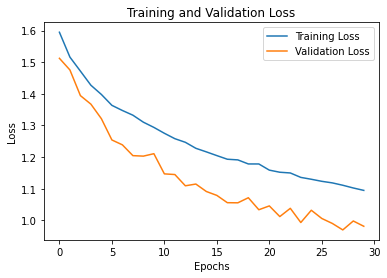

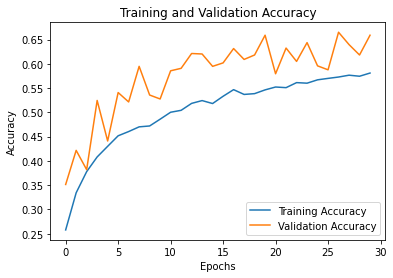

In [7]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

62/62 [==============================] - 6s 91ms/step - loss: 0.9814 - acc: 0.6589
Loss: 0.9814427495002747
Accuracy: 0.6588594913482666


In [9]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



380/380 [==============================] - 98s 255ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20631   0.25738   0.22903      1220
            covid19    0.19810   0.20113   0.19960      1243
             normal    0.16753   0.10526   0.12929      1235
       tuberculosis    0.19430   0.34359   0.24822      1170
    viral_pneumonia    0.20843   0.07756   0.11305      1212

           accuracy                        0.19572      6080
          macro avg    0.19493   0.19698   0.18384      6080
       weighted avg    0.19486   0.19572   0.18333      6080



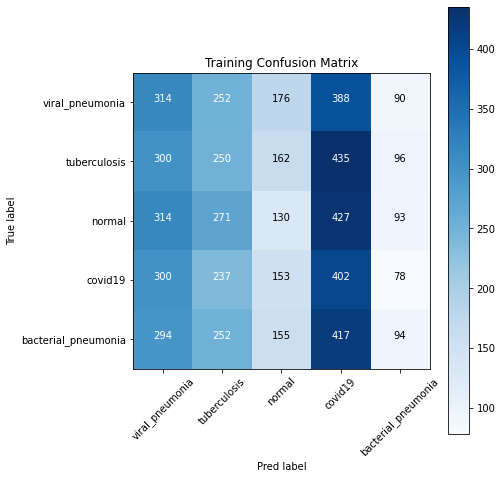

In [10]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [11]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 163845    
Total params: 20,188,229
Trainable params: 163,845
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [12]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
380/380 [==============================] - 114s 288ms/step - loss: 1.4369 - acc: 0.4377 - val_loss: 1.1436 - val_acc: 0.6130
Epoch 2/30
380/380 [==============================] - 108s 285ms/step - loss: 1.1307 - acc: 0.6234 - val_loss: 0.9126 - val_acc: 0.7189
Epoch 3/30
380/380 [==============================] - 108s 284ms/step - loss: 0.9843 - acc: 0.6719 - val_loss: 0.8030 - val_acc: 0.7312
Epoch 4/30
380/380 [==============================] - 107s 280ms/step - loss: 0.8854 - acc: 0.6998 - val_loss: 0.7326 - val_acc: 0.7566
Epoch 5/30
380/380 [==============================] - 107s 282ms/step - loss: 0.8288 - acc: 0.7174 - val_loss: 0.6813 - val_acc: 0.7597
Epoch 6/30
380/380 [==============================] - 108s 283ms/step - loss: 0.7759 - acc: 0.7378 - val_loss: 0.6472 - val_acc: 0.7811
Epoch 7/30
380/380 [==============================] - 107s 282ms/step - loss: 0.7412 - acc: 0.7495 - val_loss: 0.6228 - val_acc: 0.7811
Epoch 8/30
380/380 [============================

In [ ]:
# model_VGG19.save("VGG19_model_skenario1.h5")
# with open('history_VGG19.txt', mode='w') as file:
#    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
#    file.close()

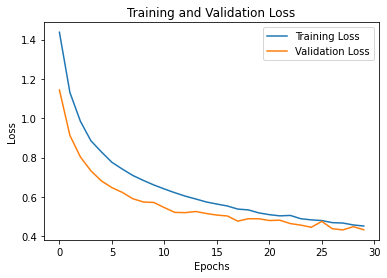

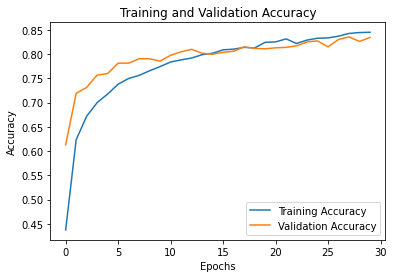

In [13]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

62/62 [==============================] - 6s 98ms/step - loss: 0.4331 - acc: 0.8340
Loss: 0.4330860674381256
Accuracy: 0.8340122103691101


In [15]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



380/380 [==============================] - 96s 253ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19442   0.18852   0.19143      1220
            covid19    0.19855   0.19871   0.19863      1243
             normal    0.19063   0.19109   0.19086      1235
       tuberculosis    0.19283   0.19316   0.19300      1170
    viral_pneumonia    0.19228   0.19719   0.19470      1212

           accuracy                        0.19375      6080
          macro avg    0.19374   0.19374   0.19372      6080
       weighted avg    0.19376   0.19375   0.19374      6080



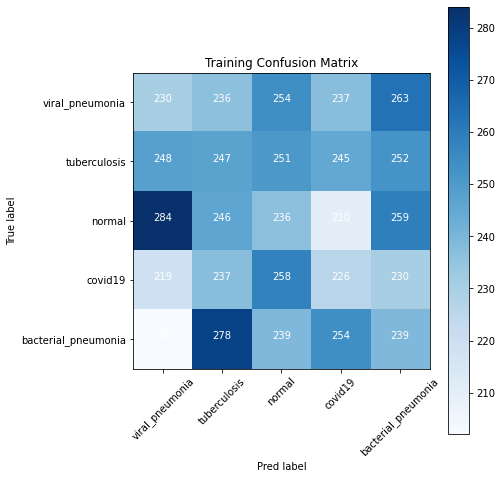

In [16]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [17]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_InceptionV3.summary())

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 368645    
Total params: 22,171,429
Trainable params: 368,645
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [18]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
380/380 [==============================] - 111s 279ms/step - loss: 1.0012 - acc: 0.5926 - val_loss: 0.7296 - val_acc: 0.6894
Epoch 2/30
380/380 [==============================] - 104s 275ms/step - loss: 0.6700 - acc: 0.7306 - val_loss: 0.5793 - val_acc: 0.7566
Epoch 3/30
380/380 [==============================] - 105s 276ms/step - loss: 0.5685 - acc: 0.7727 - val_loss: 0.5390 - val_acc: 0.7719
Epoch 4/30
380/380 [==============================] - 104s 274ms/step - loss: 0.5139 - acc: 0.8005 - val_loss: 0.5182 - val_acc: 0.7882
Epoch 5/30
380/380 [==============================] - 105s 275ms/step - loss: 0.4562 - acc: 0.8188 - val_loss: 0.5983 - val_acc: 0.7637
Epoch 6/30
380/380 [==============================] - 105s 276ms/step - loss: 0.4323 - acc: 0.8322 - val_loss: 0.4927 - val_acc: 0.8024
Epoch 7/30
380/380 [==============================] - 105s 276ms/step - loss: 0.3962 - acc: 0.8523 - val_loss: 0.4923 - val_acc: 0.7923
Epoch 8/30
380/380 [============================

In [ ]:
#model_InceptionV3.save("InceptionV3_model.h5")
#with open('history_InceptionV3.txt', mode='w') as file:
#    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
#    file.close()

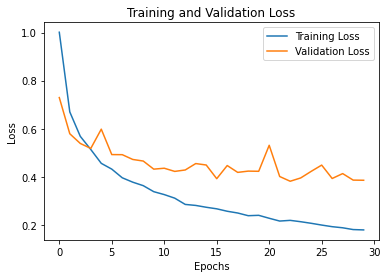

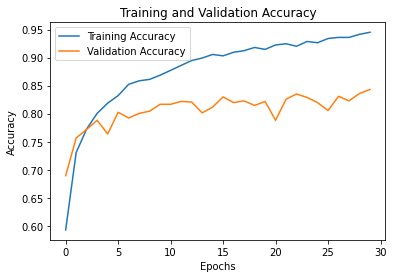

In [19]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

62/62 [==============================] - 6s 88ms/step - loss: 0.3860 - acc: 0.8432
Loss: 0.3859819173812866
Accuracy: 0.8431771993637085


In [21]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



380/380 [==============================] - 99s 258ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19675   0.17869   0.18729      1220
            covid19    0.20362   0.20837   0.20596      1243
             normal    0.20533   0.19352   0.19925      1235
       tuberculosis    0.18129   0.18547   0.18335      1170
    viral_pneumonia    0.19716   0.21782   0.20698      1212

           accuracy                        0.19687      6080
          macro avg    0.19683   0.19677   0.19657      6080
       weighted avg    0.19700   0.19687   0.19670      6080



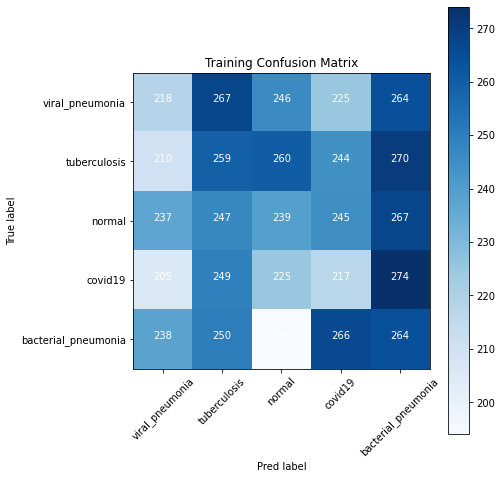

In [22]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()